In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import numpyro

from hb_mep.config import HBMepConfig
from hb_mep.data_access import DataClass
from hb_mep.models.rats.saturated_relu import SaturatedReLU

from hb_mep.utils import plot

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

#### Load config

In [3]:
config = HBMepConfig()
config.CURRENT_PATH = PARENT_PATH


#### Load data and preprocess

In [4]:
data = DataClass(config)

fpath = glob.glob(os.path.join(data.data_path, "rats_data/amap*/*/*.csv"))
df = None

for f in fpath:
    temp = pd.read_csv(f)

    participant = f.split("/")[-3]
    temp["participant"] = participant

    temp = temp[temp.channel1_segment.isna()].copy()

    temp["method"] = temp.channel2_laterality

    if df is None:
        df = temp.copy()
    else:
        df = pd.concat([df, temp], ignore_index=True).copy()

df.reset_index(drop=True, inplace=True)

df, encoder_dict = data.build(df)

df = df[df.participant.isin([0])].copy()
df = df[df.compound_position.isin([0, 1])].copy()
df.reset_index(drop=True, inplace=True)

2023-05-23 10:29:09,932 - hb_mep.data_access.core - INFO - Processing data ...
2023-05-23 10:29:09,986 - hb_mep.utils.utils - INFO - func:preprocess took: 0.05 sec
2023-05-23 10:29:09,986 - hb_mep.utils.utils - INFO - func:build took: 0.05 sec


#### Plot data

In [5]:
# plot(df, encoder_dict=encoder_dict);

#### Initialize model

In [6]:
model = SaturatedReLU(config)

#### Run MCMC inference

In [7]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-05-23 10:29:12,096 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-23 10:29:12,097 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-23 10:29:12,097 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-23 10:29:12,098 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-23 10:29:12,098 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
2023-05-23 10:29:12,136 - hb_mep.models.rats.saturated_relu - INFO - Running inference with Saturat

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

2023-05-23 10:29:24,925 - hb_mep.utils.utils - INFO - func:run_inference took: 12.83 sec


#### Diagnostics

In [8]:
mcmc.print_summary()


                           mean       std    median      5.0%     95.0%     n_eff     r_hat
             a[0,0,0]    120.75      4.95    121.75    113.17    127.99   3998.11      1.00
             a[0,1,0]    144.59     33.26    144.39     90.87    198.51  11406.64      1.00
             a[1,0,0]    144.61     33.07    144.19     89.05    196.54  11456.29      1.00
             a[1,1,0]    166.49      2.61    166.43    162.18    170.82  13906.18      1.00
            a_mean[0]    144.37     18.12    144.42    116.12    174.99   9415.34      1.00
           a_scale[0]     26.46      9.60     24.89     11.92     40.95  10312.57      1.00
             b[0,0,0]      0.01      0.00      0.01      0.01      0.01   5300.74      1.00
             b[0,1,0]      0.02      0.03      0.01      0.00      0.04  13128.41      1.00
             b[1,0,0]      0.02      0.03      0.01      0.00      0.04  13251.91      1.00
             b[1,1,0]      0.01      0.00      0.01      0.01      0.01  14239.

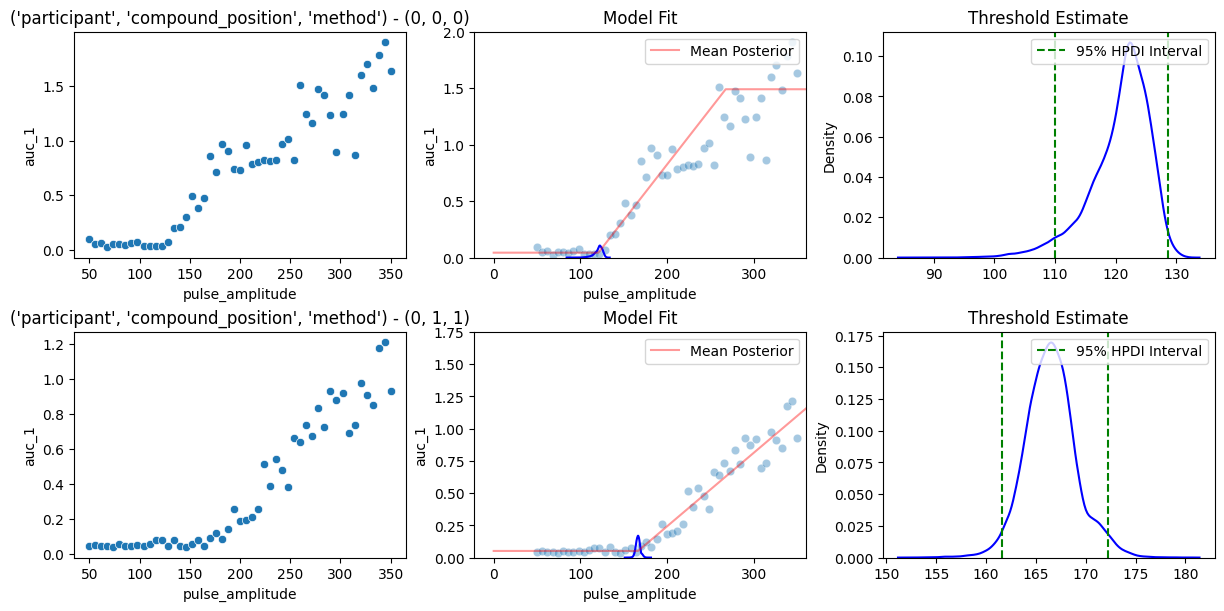

In [9]:
model.plot(df=df, posterior_samples=posterior_samples);